In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy
import pandas as pd


%matplotlib inline
plt.style.use('bmh')
plt.rcParams['figure.figsize'] = (15.0, 5.0)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['font.size'] = 16

def Stimmen_zuordnen(Stimmen):
    Stimmen = []
    temp = []
    for n, Zeile in enumerate(Zeilen):
        if "=" in Zeile:
            Stimmen.append(temp)
            temp = []
            continue
        temp.append(Zeile)
    Stimmen.append(temp)
    Stimmen.pop(0)
    print("Wir haben", len(Stimmen),"Stimmen mit", [len(Stimme) for Stimme in Stimmen], "Takten.")
    return Stimmen

def Stimmen_zu_Takten_überlagern(Stimmen):
    Takte = []
    for t in range(92):
        Takte.append((Stimmen[0][t], Stimmen[1][t], Stimmen[2][t]))
    return Takte

def damerau_levenshtein_distance(s1, s2):
    d = {}
    lenstr1 = len(s1)
    lenstr2 = len(s2)
    for i in range(-1,lenstr1+1):
        d[(i,-1)] = i+1
    for j in range(-1,lenstr2+1):
        d[(-1,j)] = j+1
    for i in range(lenstr1):
        for j in range(lenstr2):
            if s1[i] == s2[j]:
                cost = 0
            else:
                cost = 1
            d[(i,j)] = min(
                           d[(i-1,j)] + 1, # deletion
                           d[(i,j-1)] + 1, # insertion
                           d[(i-1,j-1)] + cost, # substitution
                          )
            if i and j and s1[i]==s2[j-1] and s1[i-1] == s2[j]:
                d[(i,j)] = min (d[(i,j)], d[i-2,j-2] + cost) # transposition
    return d[lenstr1-1,lenstr2-1]

In [3]:
Zeilen = np.genfromtxt("Metamorphoses_Three_02_easy_clean.out", dtype='str', delimiter='##')
Stimmen = Stimmen_zuordnen(Zeilen)
Takte = Stimmen_zu_Takten_überlagern(Stimmen)

Wir haben 3 Stimmen mit [92, 92, 92] Takten.


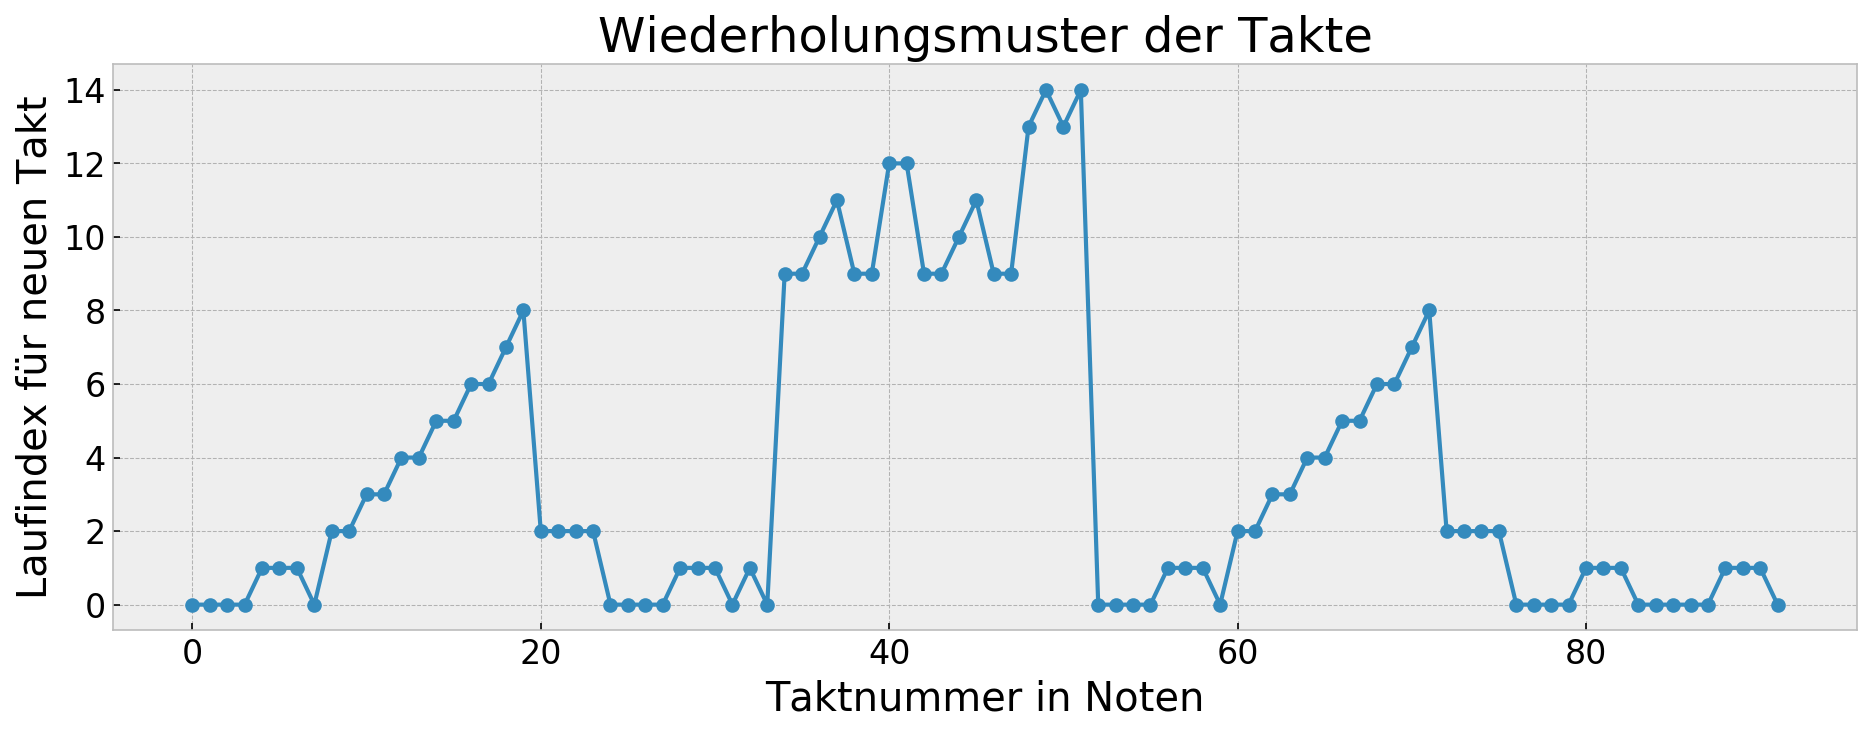

In [4]:
Taktnummern = [y for y in range(len(Takte))]
Motive = []
for Takt_a in Taktnummern:
    Motiv_neu = []
    for Takt_b in Taktnummern:
        if damerau_levenshtein_distance(Takte[Takt_a], Takte[Takt_b]) == 0:
             if Takt_b not in [item for sublist in Motive for item in sublist]:
                Motiv_neu.append(Takt_b)
    if len(Motiv_neu) !=0 :
        Motive.append(Motiv_neu)

Farben = np.empty(92)
for i ,Farbe in enumerate(Farben):
    for m, Motiv in enumerate(Motive):
        if i in Motiv:
            Farben[i] = m
plt.plot(Farben,"o-")
plt.xlabel("Taktnummer in Noten"), plt.ylabel("Laufindex für neuen Takt"), plt.title("Wiederholungsmuster der Takte")
plt.savefig("Wiederholungsmuster der Takte.png")

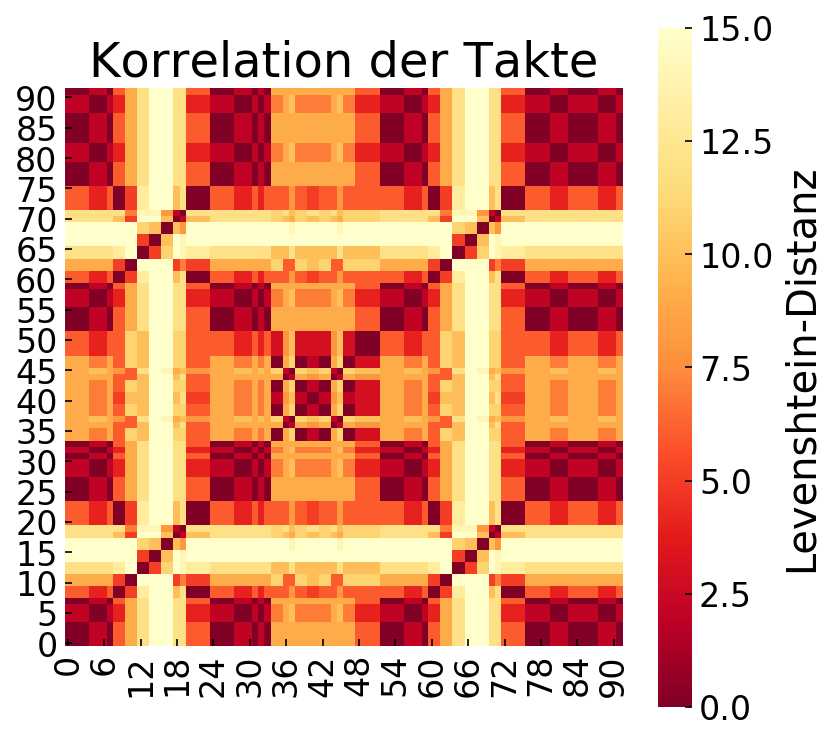

In [5]:
Takte_vereinfacht = [Takte[i][0] + Takte[i][1] + Takte[i][2] for i in range(len(Takte))]
ersetzen = [  
            ['cis','a'],
            ['dis','b'],
            ['ees','c'],
            ['fis','d'],
            ['gis','e'],
            ['ais','f'],
            ['his','g'],
            ['bes','h'],
            ['c','i'],
            ['d','j'],
            ['e','k'],
            ['f','l'],
            ['g','m'],
            ['a','n'],
            ['h','o'],
            ['r',''],
            ['<',''],
            ['>',''],
            ['(',''],
            [')',''],
            [' ',''],
]
for i in range(len(ersetzen)):
    for n in range(len(Takte_vereinfacht)):
        Takte_vereinfacht[n] = Takte_vereinfacht[n].replace(ersetzen[i][0], ersetzen[i][1])

Corr_mat = np.empty((len(Takte_vereinfacht), len(Takte_vereinfacht)))
for x in range(len(Takte)):
    for y in range(len(Takte)):
        Corr_mat[x,y] = damerau_levenshtein_distance(Takte_vereinfacht[x],Takte_vereinfacht[y])
fig = plt.figure(figsize=(6,6))
ax = sns.heatmap(Corr_mat, square=True, cmap="YlOrRd_r", cbar_kws={'label': 'Levenshtein-Distanz'})
ax.invert_yaxis(), plt.title("Korrelation der Takte"), plt.savefig("Korrelationsmatrix.png"), 
plt.show()

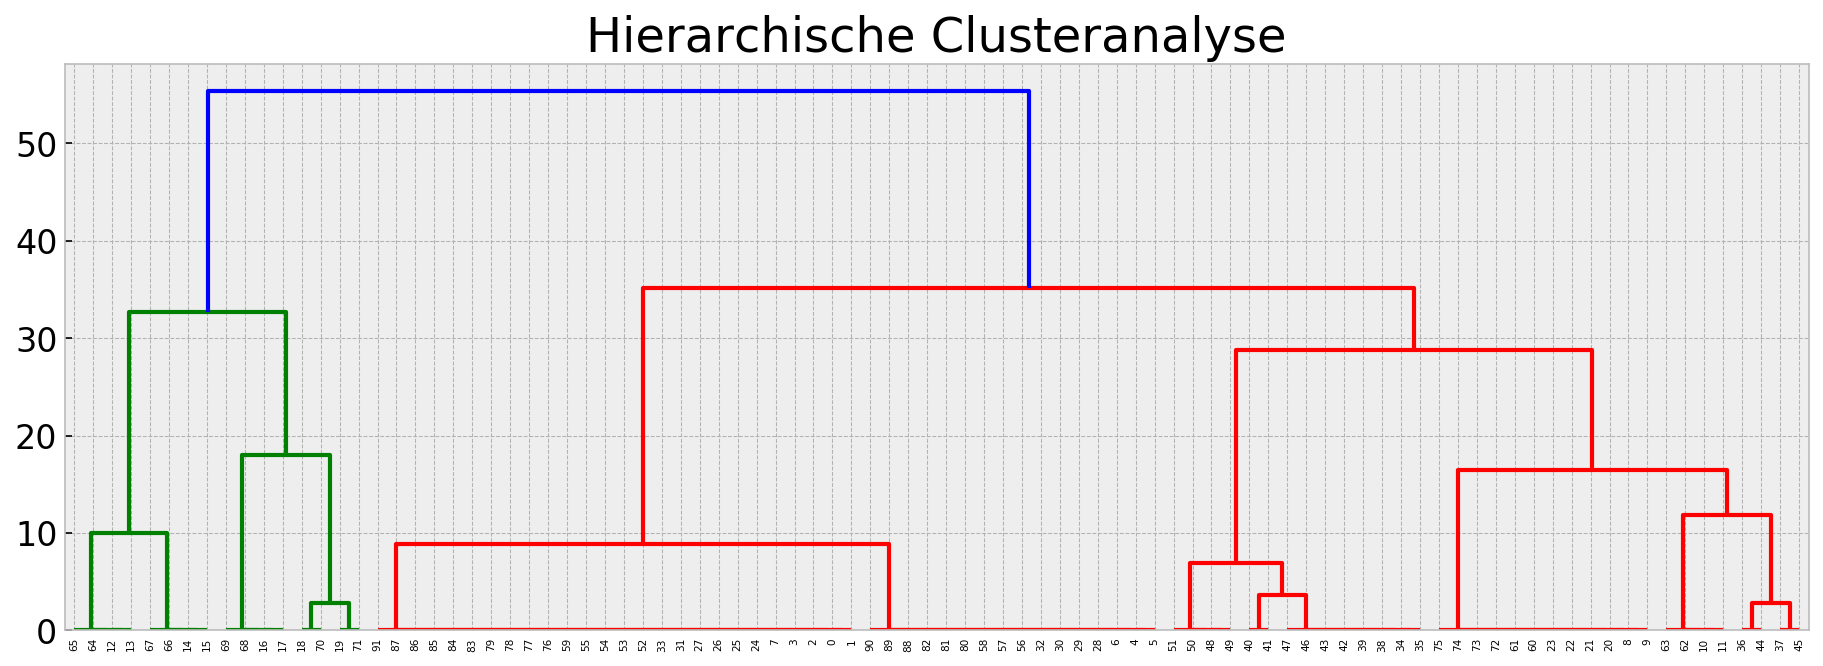

In [6]:
def d(coord):
    i, j = coord
    return damerau_levenshtein_distance(Takte_vereinfacht[i], Takte_vereinfacht[j])

upper_tria = np.triu_indices(len(Takte_vereinfacht), 1)
distance_upper_tria = np.apply_along_axis(d, 0, upper_tria)
hierarchy = scipy.cluster.hierarchy.linkage(distance_upper_tria, 'ward')
scipy.cluster.hierarchy.dendrogram(hierarchy), plt.title("Hierarchische Clusteranalyse"), plt.savefig("Cluster.png")
plt.show()

C:\Users\Sven Brieden\Anaconda3\lib\site-packages\seaborn\matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)
C:\Users\Sven Brieden\Anaconda3\lib\site-packages\seaborn\matrix.py:603: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  metric=self.metric)


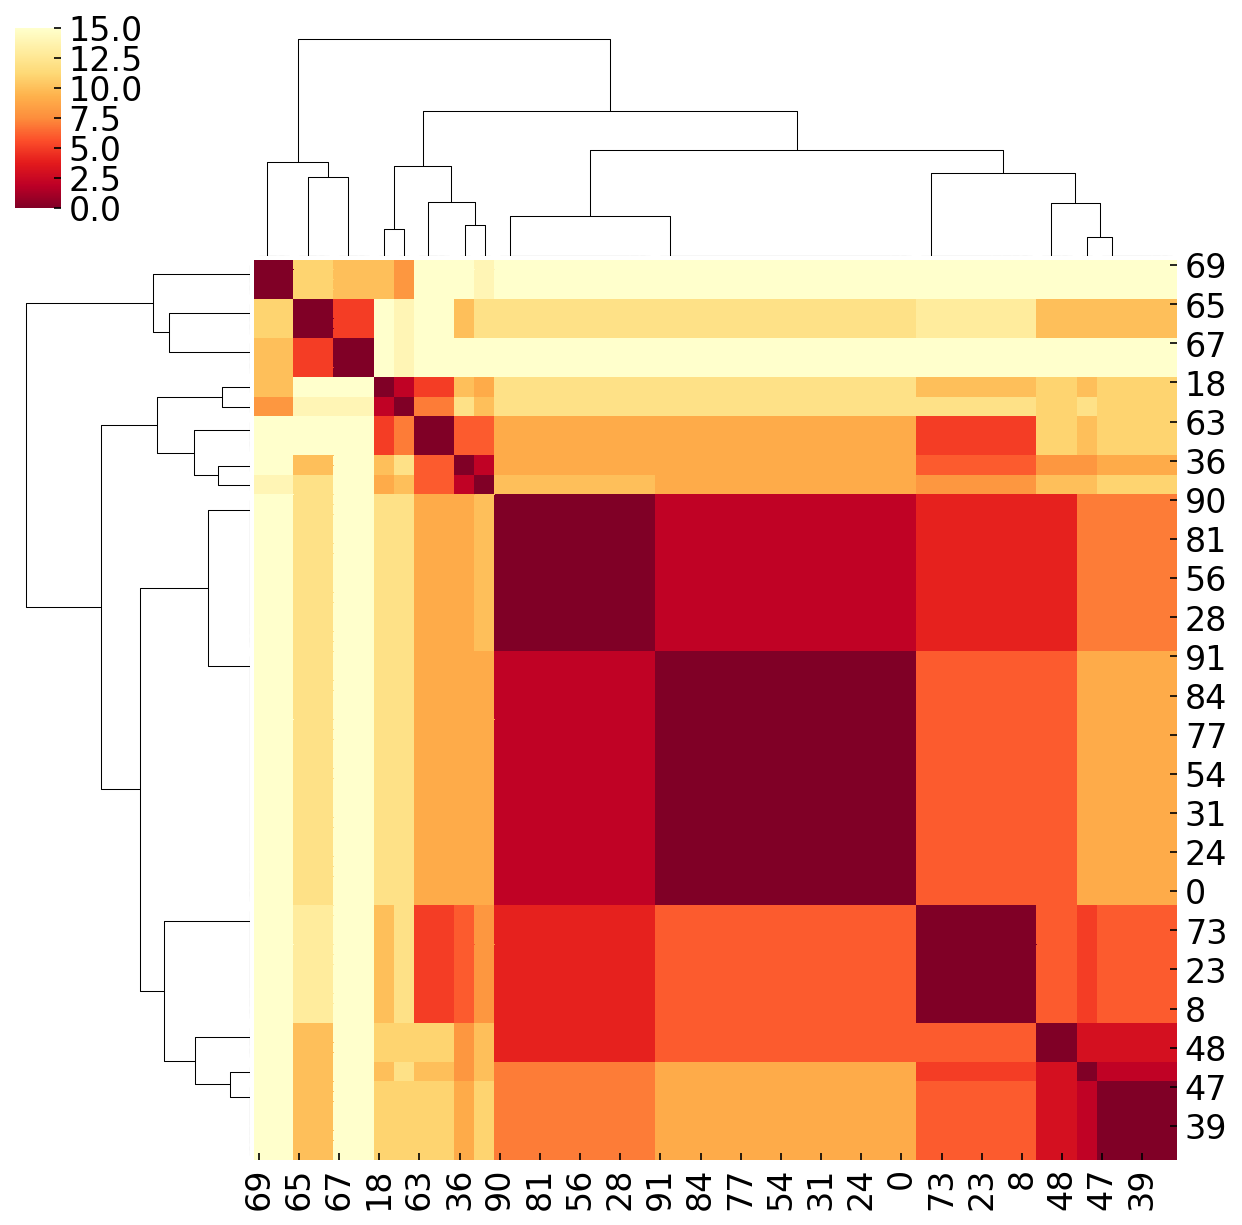

In [7]:
g = sns.clustermap(pd.DataFrame(Corr_mat), cmap="YlOrRd_r"), plt.savefig("Clustermap.png")